<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/digit_recognizer/undraw_Designer_re_5v95.png" width=400px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">MNIST - Road to 99.5% with CNN &amp; 1Cycle Scheduling</p>


In [1]:
# %load ../config.py
import glob
import os
import shutil
import subprocess
import sys
import warnings
from array import array
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial, singledispatch
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns
import shap
import tensorflow as tf
import tensorflow_datasets as tfds
from colorama import Fore, Style
from IPython.core.display import HTML, display_html
from keras import layers
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.base import BaseEstimator, OneToOneFeatureMixin, TransformerMixin
from tensorflow import keras
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate, shift

# Environment
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

K = keras.backend
AUTOTUNE = tf.data.AUTOTUNE

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

# Plots colors.
FONT_COLOR = "#4A4B52"
BACKGROUND_COLOR = "#FFFCFA"

# Data Frame color theme.
CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": "background-color: #FFFCFA",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": "color: #4A4B52; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette("#BAB8B8", as_cmap=True)

HTML_STYLE = """
    <style>
    code {
        background: rgba(42, 53, 125, 0.10) !important;
        border-radius: 4px !important;
    }
    a {
        color: rgba(123, 171, 237, 1.0) !important;
    }
    ol.numbered-list {
    counter-reset: item;
    }
    ol.numbered-list li {
    display: block;
    }
    ol.numbered-list li:before {
    content: counters(item, '.') '. ';
    counter-increment: item;
    }
    </style>
"""

# Utility functions.
def download_from_kaggle(expr, directory=None, /) -> None:
    if directory is None:
        directory = Path("data")
    if not isinstance(directory, Path):
        raise TypeError("The `directory` argument must be `Path` instance!")
    match expr:
        case ["kaggle", _, "download", *args] if args:
            directory.parent.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (directory / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, directory)
                shutil.move(filename, directory)
        case _:
            raise SyntaxError("Invalid expression!")


def get_pretty_frame(frame, /, gradient=False, formatter=None, precision=3, repr_html=False):
    stylish_frame = frame.style.set_table_styles(DF_STYLE).format(
        formatter=formatter, precision=precision
    )
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)  # type: ignore
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes("style='display:inline'")._repr_html_()
    return stylish_frame


# Html highlight. Must be included at the end of all imports!
HTML(HTML_STYLE)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Competition Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    MNIST ("Modified National Institute of Standards and Technology") is the de facto "hello world" dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Task</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. The competition evaluation metric is <a href="https://en.wikipedia.org/wiki/Accuracy_and_precision"><b>Accuracy</b></a>:
    \[\textrm{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN},\]
    where <i>TP</i> - true positive, <i>TN</i> - true negative, <i>FP</i> - false positive, <i>FN</i> - false negative,
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Table of Contents</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The table of contents provides pleasurable navigation through the whole notebook. You can easily navigate through sections and return to TOC.
</p>

<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #C73C1A;
    border-radius: 2px;
    border: 1px solid #C73C1A;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#data_loading_and_augmentation_examples"><span style="color: #F2F2F0">Data Loading &amp; Augmentation Examples</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#look_at_digits"><span style="color: #F2F2F0">Look at Digits</span></a></li>
        <li><a href="#prepare_efficient_datasets"><span style="color: #F2F2F0">Prepare Efficient Datasets</span></a></li>
    </ol>
    <li><a href="#cnn_with_one_cycle_learning_rate_policy"><span style="color: #F2F2F0">CNN with One Cycle Learning Rate Policy</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#utility_functions_and_classes"><span style="color: #F2F2F0">Utility Functions &amp; Classes</span></a></li>
        <li><a href="#cnn_architecture_and_1cycle_implementation"><span style="color: #F2F2F0">CNN Architecture &amp; 1Cycle Implementation</span></a></li>
        <li><a href="#training"><span style="color: #F2F2F0">Training</span></a></li>
    </ol>
    <li><a href="#summary"><span style="color: #F2F2F0">Summary</span></a></li>
</ol>
</blockquote>


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1</span> <span style='color: #C73C1A'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Loading &amp; Augmentation Examples</span></b><a class="anchor" id="data_loading_and_augmentation_examples"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, we load the data and split it in a stratified fashion. In that, we will have evenly deployed samples over the training and validation datasets. Moreover, we will use <code>Scipy</code> module to show example data augmentation (translations and rotations). 
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #C73C1A'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Look at Digits</span></b><a class="anchor" id="look_at_digits"></a> [↑](#top)

In [2]:
competition = "digit-recognizer"
expr = f"kaggle competitions download -c {competition}".split()

if not ON_KAGGLE:
    download_from_kaggle(expr)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, engine="pyarrow", dtype=np.uint8)
test = pd.read_csv(test_path, engine="pyarrow", dtype=np.uint8)


In [3]:
get_pretty_frame(train.head())


In [4]:
train.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: uint8(785)
memory usage: 31.4 MB


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>Insight</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Since MNIST is an image dataset, features are represented as numbers from $0$ to $255$. Therefore, I used an $8$-bit unsigned integer during loading data to save memory. Combined with the <i>pyarrow</i> engine, this gives us efficient operation. <b>Everyone knows the MNIST dataset, but let's visualize some digits.</b>
</p>

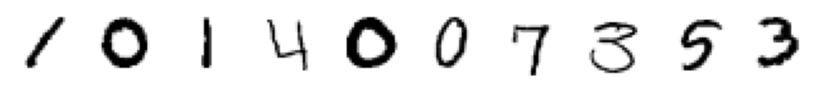

In [5]:
plt.figure(figsize=(11.5, 2), tight_layout=True, facecolor="white")

for idx, digit in enumerate(train.iloc[:10, 1:].values.reshape(-1, 28, 28)):
    plt.subplot(1, 10, idx + 1)
    plt.imshow(digit, cmap="binary")
    plt.axis("off")

plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>Sample Digits</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Well, it's obvious what these images mean for us, but for neural networks, it's good to provide additional information in the form of translations and rotations. This way, CNN will be more robust in new sample generalization. We can present some transformations with <code>Scipy</code> module as below.
</p>

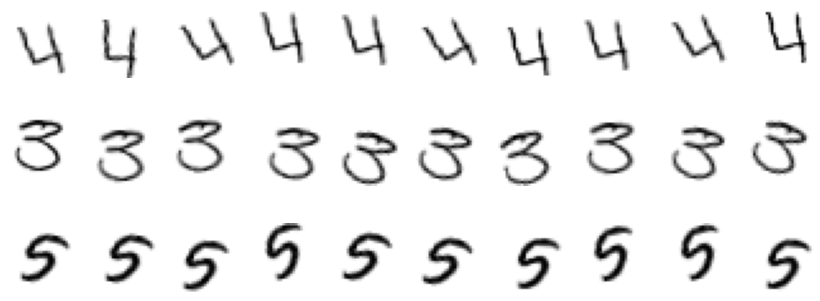

In [6]:
np.random.seed(42)

plt.figure(figsize=(11.5, 5), tight_layout=True, facecolor="white")
max_dx, max_dy, max_angle = 4, 4, 20

# Example operations with Scipy.
for row, digit in enumerate(train.iloc[[3, 7, 8], 1:].values.reshape(-1, 28, 28)):
    for col in range(10):
        dx = np.random.randint(-max_dx, max_dx)
        dy = np.random.randint(-max_dy, max_dy)
        angle = np.random.randint(-max_angle, max_angle)

        shifted = shift(digit, (dx, dy))
        rotated = rotate(shifted, angle, order=1, reshape=False)

        plt.subplot(3, 10, (col + 1) + row * 10)
        plt.imshow(rotated, cmap="binary")
        plt.axis("off")

plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>Sample Transformations</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Looks good. Now, we can prepare training and validation datasets and maximize their performance with the <code>tf.data</code> API, simultaneously including augmentation layers in the preprocessing pipeline.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #C73C1A'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Prepare Efficient Datasets</span></b><a class="anchor" id="prepare_efficient_datasets"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Let's split the given data into training and validation subsets. We will allocate $12.5$% on validation. <b>Thus each digit should be represented by around $500$ examples in the validation subset.</b>
</p>

In [7]:
X_test = test.values.reshape(-1, 28, 28, 1)

X_train_full = train.drop("label", axis=1).values.reshape(-1, 28, 28, 1)
y_train_full = train.label.values

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.125,
    stratify=y_train_full,  # type: ignore
    shuffle=True,
    random_state=42,
)

print(f"{CLR}{'Train Shape:':15s}", f"{RED}{X_train.shape}")
print(f"{CLR}{'Valid Shape:':15s}", f"{RED}{X_valid.shape}")
print(f"{CLR}{'Test Shape:':15s}", f"{RED}{X_test.shape}")


Train Shape:    (36750, 28, 28, 1)
Valid Shape:    (5250, 28, 28, 1)
Test Shape:     (28000, 28, 28, 1)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>Train - Validation Split</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here, I split the entire training dataset into training and validation one in a <b>stratified fashion</b> since more or fewer digits correspond to each class. Moreover, I included one channel colour since CNN requires that. Now let's get to preparing <code>TensorFlow</code> datasets.
</p>

In [8]:
def get_dataset_from_slices(
    X, y, batch_size=32, cache=True, shuffle=False, shuffle_buffer_size=5000, seed=None
):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if cache:
        dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer_size, seed=seed, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, num_parallel_calls=AUTOTUNE)
    return dataset.prefetch(AUTOTUNE)


In [9]:
benchmark_ds = get_dataset_from_slices(X_train, y_train, shuffle=True, seed=42)
bench_results = tfds.benchmark(benchmark_ds, batch_size=32)



************ Summary ************



  0%|          | 0/1149 [00:00<?, ?it/s]

Examples/sec (First included) 115180.19 ex/sec (total: 36800 ex, 0.32 sec)
Examples/sec (First only) 225.44 ex/sec (total: 32 ex, 0.14 sec)
Examples/sec (First excluded) 207081.13 ex/sec (total: 36768 ex, 0.18 sec)


In [11]:
train_ds = get_dataset_from_slices(X_train, y_train, shuffle=True, seed=42)
valid_ds = get_dataset_from_slices(X_valid, y_valid)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>Tensorflow Datasets</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Datasets seem to be efficient enough. Now, we can get to the CNN architecture and 1Cycle implementation.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #C73C1A'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">CNN with One Cycle Learning Rate Policy</span></b><a class="anchor" id="cnn_with_one_cycle_learning_rate_policy"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, we will implement the 1Cycle learning schedule and CNN architecture, which breaks $99.5$% accuracy on the MNIST dataset. Moreover, I will test a few not so common elements like depth pooling layer and Swish activation function with a trainable $\beta$ parameter.<br><br>
    The cyclic learning rate (and also momentum) is an exciting learning rate scheduling technique for faster convergence: <a href="https://arxiv.org/abs/1708.07120"><b>Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates</b></a>. The working principle is relatively easy to understand. <b>We start with a given learning rate (usually $10$ times smaller than the maximum) and allow it to rise to the maximal value (where the solution diverges) roughly by the first half of training. In the second half, the learning rate drops as fast as it grew before, and for the last few epochs, we reduce it such that the final value is roughly $1000$ times lower than the starting learning rate.</b> On the other hand, the rule with cyclic momentum is inverted. We set the maximum and minimum values of momentum (usually to $0.95$ and $0.85$, respectively), but firstly it falls and then rises. There are at least two solutions. One of them is implemented using linear annealing (as depicted above). The second uses cosine annealing, which gives smooth curves. In this notebook, I'll use a cosine one, but the implementation allows you to test different approaches.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.1</span> <span style='color: #C73C1A'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Utility Functions &amp; Classes</span></b><a class="anchor" id="utility_functions_and_classes"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Before we start with 1Cycle, we need to write small tools to find the maximal learning rate. To do this, we use <code>ExponentialLearningRate</code> callback that multiplies the optimizer's learning rate by a constant factor at the end of each batch and stores these values. The second thing is the <code>get_lr_vs_loss()</code> function which applies this callback over one epoch.
</p>

In [12]:
class ExponentialLearningRate(keras.callbacks.Callback):
    """For internal use. `ExponentialLearningRate` callback multiplies
    the optimizer's learning rate by a constant factor at the end of each batch."""

    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.rates.append(lr)
        self.losses.append(logs["loss"])  # type: ignore
        K.set_value(self.model.optimizer.learning_rate, lr * self.factor)


In [13]:
def get_lr_vs_loss(model, dataset, min_lr=1e-4, max_lr=1e-1):
    """For internal use. It takes a given model and performs one learning epoch
    successive increasing learning rate within `ExponentialLearningRate` callback.
    The maximal learning rate appropriate for the One Cycle Learning Rate Policy
    is a value which is located nearly before the divergent solution."""

    init_weights = model.get_weights()
    batches = dataset.cardinality().numpy()
    lr_factor = (max_lr / min_lr) ** (1.0 / batches)
    lr_init = K.get_value(model.optimizer.learning_rate)

    exp_lr = ExponentialLearningRate(lr_factor)
    model.fit(dataset, epochs=1, callbacks=[exp_lr])

    K.set_value(model.optimizer.learning_rate, lr_init)
    model.set_weights(init_weights)

    return pd.DataFrame({"Learning Rate": exp_lr.rates, "Loss": exp_lr.losses})


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>MaxDepthPool2D Layer</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As we know, we usually use average pooling layers or max pooling layers in CNNs; nevertheless, I decided to use a depth pooling layer here. This solution isn't so common, but I'm just curious. <b>The point is that max op is performed along the depth dimension, and the network can learn invariance over different features.</b> For example, it can learn invariance to translations and rotations.
</p>

In [14]:
class MaxDepthPool2D(keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # The number of channels is stored in shape[-1].
        groups = shape[-1] // self.pool_size  # Number of channel groups.
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)


In [15]:
np.random.seed(42)

# Kernel size must be a divisor of the number of input maps.
maps = np.random.randn(1, 28, 28, 32)
output = MaxDepthPool2D(pool_size=2)(maps)

print(f"{CLR}{'Maps Shape:':15s}", f"{RED}{maps.shape}")
print(f"{CLR}{'Output Shape:':15s}", f"{RED}{output.shape}")


Maps Shape:     (1, 28, 28, 32)
Output Shape:   (1, 28, 28, 16)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>Generalized Swish Activation Function</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The second thing is to introduce a generalized Swish activation function: <a href="https://arxiv.org/abs/1710.05941"><b>Searching for Activation Functions</b></a>. As far as I know, the Swish function is available in <code>Keras</code> but without a trainable $\beta$ parameter. Swish generally should improve model performance, but it's more computationally demanding than typically used ReLU. If $\beta \rightarrow \infty$, then Swish is equivalent to ReLU. See below.
</p>

In [16]:
class GeneralizedSwish(keras.layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = tf.Variable(
            initial_value=beta,
            trainable=kwargs.get("trainable", True),
            dtype=tf.float32,
        )

    def call(self, x):
        return x / (1.0 + tf.exp(-self.beta * x))

    def get_config(self):
        return super().get_config() | {"beta": self.beta}


In [17]:
def swish(x, beta=1.0):
    return x / (1.0 + np.exp(-beta * x))


# Create figure
fig = go.Figure()
beta_sign = "\u03b2"
betas = np.arange(0, 5, 0.1)

# Add traces, one for each slider step
for beta in betas:
    fig.add_scatter(
        visible=False,
        line=dict(color="#C73C1A", width=3),
        name="",
        x=np.arange(-4, 4, 0.01),
        y=swish(np.arange(-4, 4, 0.01), beta),
        hovertemplate="x=%{x}<br>\u03b2=" f"{beta}" "<br>y=Swish<sub>\u03b2</sub>(%{x})",
    )
fig.update_traces(opacity=0.75)

# Make 10th trace visible
fig.data[10].visible = True  # type: ignore

# Create and add slider
steps = []
for i, beta in enumerate(betas):  # type: ignore
    step = dict(
        method="update",
        label=f"{beta:.1f}",
        args=[
            {"visible": [False] * len(fig.data)},  # type: ignore
            {
                "title": "Generalized Swish Activation Function: "
                f"Swish<sub>{beta_sign}={beta:.1f}</sub>(x)"
            },
        ],
    )
    step["args"][0]["visible"][i] = True  # type: ignore Toggle i'th trace to "visible"
    steps.append(step)

sliders = [
    dict(
        active=10,
        currentvalue={"prefix": f"{beta_sign}: "},
        pad={"t": 50},
        steps=steps,
        bgcolor="rgba(68, 68, 68, 0.25)",
    )
]

fig.add_annotation(
    x=-3.8,
    y=2,
    align="left",
    xanchor="left",
    text=f"<b>We will allow CNN to learn the {beta_sign} parameter.</b>",
    showarrow=False,
)
fig.add_hline(y=0, line_width=2, line_dash="dash", line_color="rgba(68, 68, 68, 0.25)")
fig.add_vline(x=0, line_width=2, line_dash="dash", line_color="rgba(68, 68, 68, 0.25)")
fig.update_layout(
    font_color=FONT_COLOR,
    title=f"Generalized Swish Activation Function: Swish<sub>{beta_sign}={betas[10]:.1f}</sub>(x)",
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    width=840,
    height=480,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_title="x",
    sliders=sliders,
)
fig.show()


## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.2</span> <span style='color: #C73C1A'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">CNN Architecture &amp; 1Cycle Implementation</span></b><a class="anchor" id="cnn_architecture_and_1cycle_implementation"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    To build the best possible MNIST CNN, I used clues from this notebook: <a href="https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist/notebook"><b>How to choose CNN Architecture MNIST</b></a>. I encourage you to get familiar with this. However, I use several different methods, i.e., Swish activation after batch normalization, max depth pooling layers and one-cycle learning rate.
</p>

In [58]:
K.clear_session()
keras.utils.set_random_seed(42)

DefaultConv2D = partial(
    layers.Conv2D,
    filters=32,
    kernel_size=3,
    strides=1,
    padding="valid",
    use_bias=False,
    kernel_initializer="he_normal",
)

augmentation_and_preprocess = keras.Sequential(
    [
        # Subjective factors.
        layers.RandomRotation(0.05, fill_mode="nearest"),
        layers.RandomTranslation(0.1, 0.1, fill_mode="nearest"),
        layers.RandomZoom(0.1, 0.1, fill_mode="nearest"),
        layers.Rescaling(scale=1 / 127.5, offset=-1.0),  # [-1, 1]
    ]
)

cnn_classifier = keras.Sequential(
    [
        DefaultConv2D(filters=32),
        layers.BatchNormalization(),
        GeneralizedSwish(),
        DefaultConv2D(filters=32),
        layers.BatchNormalization(),
        GeneralizedSwish(),
        MaxDepthPool2D(pool_size=2),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        #
        DefaultConv2D(filters=64, padding="same"),
        layers.BatchNormalization(),
        GeneralizedSwish(),
        DefaultConv2D(filters=64, padding="same"),
        layers.BatchNormalization(),
        GeneralizedSwish(),
        MaxDepthPool2D(pool_size=4),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        #
        layers.Flatten(),
        layers.Dense(128, use_bias=False, kernel_initializer="he_normal"),
        layers.BatchNormalization(),
        GeneralizedSwish(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

cnn_model = keras.Sequential([augmentation_and_preprocess, cnn_classifier])
cnn_model.build(input_shape=(None, 28, 28, 1))
cnn_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>CNN Architecture</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Since we have CNN architecture, it's time to find maximal learning rate for 1Cycle. <b>The max learning rate appropriate for that is nearly two times lower than the learning rate where the solution is divergent.</b>
</p>

In [38]:
lr_vs_loss = get_lr_vs_loss(cnn_model, train_ds)


1149/1149 [==============================] - 21s 16ms/step - loss: nan - accuracy: 0.6491


In [39]:
fig = px.line(
    lr_vs_loss,
    x="Learning Rate",
    y="Loss",
    height=480,
    width=840,
    log_x=True,
    log_y=True,
    title="CNN with RMSProp Optimizer - Learning Rate vs Loss over One Epoch<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "The maximum learning rate seems to be in the (0.01, 0.02) range</span>",
)
fig.update_traces(line_color="#c73c1a", opacity=0.75)
fig.update_xaxes(showgrid=False, range=(-3.1, -0.1))
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)

fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>Solution Divergency</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <b>As you can see, the solution is divergent, nearly the learning rate equal to $0.02 - 0.10$. We need to choose a slightly smaller value, but we cannot overdo it. Let's take $0.01$.</b><br><br>
    Now we can handle the 1Cycle implementation. As you can see below, <code>OneCycleLearningRatePolicy</code> takes several parameters:
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <li><code>max_lr</code> - maximum learning rate (we've just found it).</li>
    <li><code>start_factor</code> - factor by which multiply <code>max_lr</code> at the beginning of training.</li>
    <li><code>final_factor</code> - factor by which multiply <code>max_lr</code> at the final stage of training.</li>
    <li><code>max_momentum</code> - max value of momentum.</li>
    <li><code>min_momentum</code> - min value of momentum.</li>
    <li><code>cycle_momentum</code> - whether cycle momentum or not.</li>
    <li><code>pct_up</code> - percentage value of training time where learning rate rises and momentum drops.</li>
    <li><code>annealing</code> - annealing function (cosine or linear).</li>
</ul>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>Implementation can be found below.</b>
</p>

In [40]:
class OneCycleLearningRatePolicy(keras.callbacks.Callback):
    """Implementation of One Cycle Learning Rate Policy - https://arxiv.org/abs/1708.07120."""

    def __init__(
        self,
        max_lr,
        start_factor=1e-1,
        final_factor=1e-4,
        max_momentum=0.95,
        min_momentum=0.85,
        cycle_momentum=False,
        pct_up=0.3,
        annealing="cosine",
    ):
        if not annealing in ("cosine", "linear"):
            raise ValueError("Invalid annealing type. Choose 'cosine' or 'linear'!")
        self.max_lr = max_lr
        self.start_lr = max_lr * start_factor
        self.final_lr = max_lr * final_factor
        self.max_momentum = max_momentum
        self.min_momentum = min_momentum
        self.cycle_momentum = cycle_momentum
        self.pct_up = pct_up
        self.learning_rates = []
        self.momentum_rates = []
        self._anneal_func = getattr(self, "_" + annealing + "_anneal")
        self._momentum_attrs = ("momentum", "beta_1")
        self._current_step = 0

    def on_train_begin(self, logs=None):
        self._steps_total = self.params["steps"] * self.params["epochs"]
        self._steps_up = int(self._steps_total * self.pct_up)
        self._steps_down = self._steps_total - self._steps_up

        opt = self.model.optimizer
        self._momentum = next(
            (getattr(opt, attr) for attr in self._momentum_attrs if hasattr(opt, attr)), None
        )
        if self.cycle_momentum and self._momentum is None:
            self.cycle_momentum = False
            warnings.warn("This optimizer does not support momentum! Cycling disabled.")

    def on_batch_begin(self, batch, logs=None):
        if self._current_step <= self._steps_up:
            pct = self._current_step / self._steps_up
            learning_rate = self._anneal_func(self.start_lr, self.max_lr, pct)
            momentum = self._anneal_func(self.max_momentum, self.min_momentum, pct)
        else:
            pct = (self._current_step - self._steps_up) / self._steps_down
            learning_rate = self._anneal_func(self.max_lr, self.final_lr, pct)
            momentum = self._anneal_func(self.min_momentum, self.max_momentum, pct)

        K.set_value(self.model.optimizer.learning_rate, learning_rate)
        if self.cycle_momentum:
            K.set_value(self._momentum, momentum)

        self.learning_rates.append(learning_rate)
        self.momentum_rates.append(momentum)
        self._current_step += 1

    def _cosine_anneal(self, lr1, lr2, pct):
        return lr2 + (lr1 - lr2) * (np.cos(np.pi * pct) + 1.0) * 0.5

    def _linear_anneal(self, lr1, lr2, pct):
        return lr1 + (lr2 - lr1) * pct


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>1Cycle Implementation</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    I tested this callback a little, and everything seems to work fine. However, setting momentum value is bugged, therefore we cannot do it. Nevertheless, it works under <code>TensorFlow</code> $2.8.4$.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.3</span> <span style='color: #C73C1A'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Training</span></b><a class="anchor" id="training"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Everything is almost ready. However, I decided to add a small Colorama callback that should slightly prettify the output.
</p>

In [41]:
class ColoramaVerbose(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            f"{CLR}Epoch: {RED}{epoch + 1:02d}{CLR} -",
            f"{CLR}loss: {RED}{logs['loss']:.5f}{CLR} -",
            f"{CLR}accuracy: {RED}{logs['accuracy']:.5f}{CLR} -",
            f"{CLR}val_loss: {RED}{logs['val_loss']:.5f}{CLR} -",
            f"{CLR}val_accuracy: {RED}{logs['val_accuracy']:.5f}",
        )


In [59]:
K.clear_session()
keras.utils.set_random_seed(42)

one_cycle_cb = OneCycleLearningRatePolicy(1e-2, cycle_momentum=False)
colorama_cb = ColoramaVerbose()

cnn_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)

cnn_history = cnn_model.fit(
    train_ds,
    epochs=25,
    validation_data=valid_ds,
    callbacks=[one_cycle_cb, colorama_cb],
    use_multiprocessing=True,
    verbose=0,
)


Epoch: 01 - loss: 0.35602 - accuracy: 0.89165 - val_loss: 0.09959 - val_accuracy: 0.97200
Epoch: 02 - loss: 0.17838 - accuracy: 0.94623 - val_loss: 0.17436 - val_accuracy: 0.95257
Epoch: 03 - loss: 0.16393 - accuracy: 0.95059 - val_loss: 0.23139 - val_accuracy: 0.93962
Epoch: 04 - loss: 0.15382 - accuracy: 0.95388 - val_loss: 0.08967 - val_accuracy: 0.97543
Epoch: 05 - loss: 0.15367 - accuracy: 0.95448 - val_loss: 0.08748 - val_accuracy: 0.97829
Epoch: 06 - loss: 0.14515 - accuracy: 0.95741 - val_loss: 0.13514 - val_accuracy: 0.97010
Epoch: 07 - loss: 0.14653 - accuracy: 0.96005 - val_loss: 0.08576 - val_accuracy: 0.98419
Epoch: 08 - loss: 0.13321 - accuracy: 0.96283 - val_loss: 0.08366 - val_accuracy: 0.97962
Epoch: 09 - loss: 0.11922 - accuracy: 0.96620 - val_loss: 0.05908 - val_accuracy: 0.98857
Epoch: 10 - loss: 0.11789 - accuracy: 0.96857 - val_loss: 0.07707 - val_accuracy: 0.98076
Epoch: 11 - loss: 0.10841 - accuracy: 0.96999 - val_loss: 0.08964 - val_accuracy: 0.98514
Epoch: 12 

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>CNN Evaluation Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Now, we could have evaluated the model as usual in test mode. Nevertheless, such an approach will vary, and we get different results fluctuating around $99.4$% on the validation dataset. Here, I want to introduce a powerful regularization technique, i.e. <b>Monte Carlo Regularization.</b> The point is that the <code>Dropout</code> layer remains active during prediction, so that all predictions will differ slightly. We can collect, for example, $100$ predictions and calculate mean probabilities. In this way, we get a more reliable estimation. To do this, we must swap <code>Dropout</code> layers with <code>MCDropout</code> layers that remain active during prediction. The whole process looks as below. 
</p>

In [60]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs, training=None):
        # Dropout remains active during prediction.
        return super().call(inputs, training=True)


In [61]:
K.clear_session()
keras.utils.set_random_seed(42)

mc_cnn_model = keras.Sequential(
    [
        augmentation_and_preprocess,
        *[
            MCDropout(layer.rate) if isinstance(layer, keras.layers.Dropout) else layer
            for layer in cnn_classifier.layers
        ],
    ]
)
mc_cnn_model.build(input_shape=(None, 28, 28, 1))
mc_cnn_model.set_weights(cnn_model.get_weights())

mc_valid_results = (
    np.stack([mc_cnn_model.predict(valid_ds, verbose=0) for _ in range(10)], axis=0)
    .mean(axis=0)  # Mean probability of class for each sample from 10 predictions.
    .argmax(axis=1)  # Class with max mean probability.
)

mc_accuracy = (mc_valid_results == y_valid).sum() / len(y_valid)
print(f"{CLR}{'Monte Carlo Valid Accuracy:':30s}", f"{RED}{mc_accuracy:.5f}")


Monte Carlo Valid Accuracy:    0.99543


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>Monte Carlo Estimation Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    We've got above $99.5$% accuracy for the validation dataset. Moreover, this estimation is robust and may vary between different kernels but only slightly .Let's have a look at the learning rate and momentum changes during the training yet.
</p>

In [62]:
one_cycle_rates = pd.DataFrame(
    {
        "Step": range(len(one_cycle_cb.learning_rates)),
        "Learning Rate": one_cycle_cb.learning_rates,
        "Momentum Rate": one_cycle_cb.momentum_rates,
    }
)

fig = make_subplots(
    rows=1,
    cols=2,
    x_title="Training Step",
    y_title="Value",
    subplot_titles=("Learning Rate", "Momentum (beta_1) Rate"),
)
fig.update_annotations(font_size=14)

fig.add_scatter(
    x=one_cycle_rates["Step"],
    y=one_cycle_rates["Learning Rate"],
    name="Learning Rate",
    line=dict(color="#c73c1a"),
    row=1,
    col=1,
)
fig.add_scatter(
    x=one_cycle_rates["Step"],
    y=one_cycle_rates["Momentum Rate"],
    name="Momentum Rate",
    line=dict(color="#c73c1a"),
    row=1,
    col=2,
)
fig.update_traces(opacity=0.75)
fig.update_xaxes(
    range=(-one_cycle_rates.Step.max() * 0.05, one_cycle_rates.Step.max() * 1.1), showgrid=False
)
fig.update_yaxes(
    range=(
        -one_cycle_rates["Learning Rate"].max() * 0.05,
        one_cycle_rates["Learning Rate"].max() * 1.1,
    ),
    row=1,
    col=1,
    showgrid=False,
)
fig.update_yaxes(range=(0.84, 0.96), row=1, col=2, showgrid=False)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    height=420,
    width=840,
    title_text="CNN with RMSProp Optimizer - 1Cycle Scheduling",
    showlegend=False,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #C73C1A;
">
    <b>1Cycle Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Well, it looks as it should. Theoretically, I could use early stopping here, but then it's highly probable we wouldn't have seen the entire scheduling curve. Now, we can prepare predictions and submit the final submission.
</p>

In [ ]:
mc_test_results = (
    np.stack([mc_cnn_model.predict(X_test, verbose=0) for _ in range(10)], axis=0)
    .mean(axis=0)  # Mean probability of class for each sample from 10 predictions.
    .argmax(axis=1)  # Class with max mean probability.
)

sumbission = pd.DataFrame({"ImageID": range(1, len(X_test) + 1), "Label": mc_test_results})
sumbission.set_index("ImageID").to_csv("submission.csv")
get_pretty_frame(sumbission.head())


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3</span> <span style='color: #C73C1A'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Summary</span></b><a class="anchor" id="summary"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    That's all in this notebook. I hope you like it, and if yes, then leave an upvote. If you have any questions, let me know in the comments section. Moreover, I encourage you to check my other notebooks. Thanks, and good luck!
</p>